In [34]:
%run ../robustness_analysis.ipynb

## Define the environment

In [2]:
# Create a mutated environment
from gym.envs.classic_control import CartPoleEnv
from types import SimpleNamespace

class MutatedCartPoleEnv(CartPoleEnv):
    def __init__(self, masscart = 1.0, masspole = 0.1, length = 0.5, force_mag = 10.0):
        super().__init__()
        
        self.spec = SimpleNamespace()
        self.spec.id = f"MutatedCartPole-{masscart:.3f}-{masspole:.3f}-{length:.3f}-{force_mag:.3f}"
        
        self.gravity = 9.8
        self.masscart = masscart
        self.masspole = masspole
        self.total_mass = self.masspole + self.masscart
        self.length = length  # actually half the pole's length
        self.polemass_length = self.masspole * self.length
        self.force_mag = force_mag
        self.tau = 0.02  # seconds between state updates
    
    def reset_to(self, state, seed=None):
        self.seed(seed)
        self.state = state
        self.steps_beyond_done = None
        return np.array(self.state, dtype=np.float32)

In [3]:
masscart = [0.1, 2.0]
force_mag = [1.0, 20.0]

# define the range of the deviation parameters
dev_bounds = np.asarray([masscart, force_mag])

# define the range of the initial states
x0_bounds = np.repeat([[-0.05, 0.05]], 4, axis=0)

# define the deviation parameter value for the original environment (no deviation)
delta_0 = np.asarray([
    1.0, # default masscart (not normalized)
    10.0 # default force_mag
])

In [4]:
def env_builder(delta):
    return MutatedCartPoleEnv(masscart=delta[0], force_mag=delta[1]), x0_bounds

## Define the agent

In [5]:
from stable_baselines3 import DQN

model = DQN.load("best_dqn_3.7")

agent = {
    # define the action generation function of the given agent
    'next_action': lambda obs: model.predict(obs, deterministic=True)[0],
    # some agents (like PID) needs to be reset for each run
    'model_reset': None
}

## Define the STL property

In [6]:
obs_space = MutatedCartPoleEnv().observation_space
pos_range = np.asarray([obs_space.low[0], obs_space.high[0]])
angle_range = np.asarray([obs_space.low[2], obs_space.high[2]])

def stl_prop():
    pos = stl.Predicate('pos')
    angle = stl.Predicate('angle')

    pos_threshold = normalize(2.4, pos_range)
    angle_threshold = normalize(12 * 2 * np.pi / 360, angle_range)

    return stl.Always( (pos < pos_threshold) & (angle < angle_threshold) )


def signal_builder(record, time_index):
    return {
        "pos": stl.Signal(
            normalize(np.abs(record[:, 0]), pos_range),
            time_index
        ),
        "angle": stl.Signal(
            normalize(np.abs(record[:, 2]), angle_range),
            time_index
        )
    }

def episode_eval(obs_record, reward_record):
    return compute_stl_rob(stl_prop(), signal_builder, obs_record)

## Define distance metric

In [7]:
# l-2 norm distance
def dist(delta, delta_0):
    delta = normalize(delta, dev_bounds)
    delta_0 = normalize(delta_0, dev_bounds)
    return np.sqrt(np.sum((delta - delta_0) ** 2))

## Start analysis

In [8]:
if not os.path.exists('gifs'):
    os.mkdir('gifs')
if not os.path.exists('data'):
    os.mkdir('data')

In [9]:
from datetime import datetime

In [35]:
analysis = RobustnessAnalysis(env_builder, agent, episode_eval, delta_0, dev_bounds, dist)
analysis.options['falsification_num_trials'] = 1
analysis.options

{'epsilon': 0.01,
 'deviation_num_trials': 3,
 'deviation_sigma': 0.2,
 'deviation_timeout': 10,
 'falsification_sigma': 0.2,
 'falsification_timeout': 1,
 'falsification_num_trials': 1,
 'falsification_episodes': 100,
 'episodes_of_each_x0': 1,
 'steps_of_each_x0': 200}

In [11]:
start = datetime.now()
delta, delta_dist = analysis.any_unsafe_deviation()


================ Any unsafe deviation trial 1 ==============>
(3_w,6)-aCMA-ES (mu_w=2.0,w_1=63%) in dimension 2 (seed=954449, Sat Nov 19 20:42:53 2022)


/home/cj/miniconda3/envs/rl_robust/lib/python3.7/site-packages/gym/envs/classic_control/cartpole.py:151: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  "You are calling 'step()' even though this "


Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      6 -2.500000069568836e-01 1.0e+00 2.65e-01  2e-01  4e-01 0:40.9
termination on ftarget=0.0 (Sat Nov 19 20:43:42 2022)
final/bestever f-value = -2.500000e-01 -2.500000e-01
incumbent solution: [0.4999853715145769, 0.1287053309642454]
std deviation: [0.2201776001601456, 0.376994448117691]


In [12]:
print('Time to find any unsafe deviation:', datetime.now() - start)
print(delta, delta_dist)

Time to find any unsafe deviation: 0:00:49.431107
[1.04997221 3.44540129] 0.34598002603218564


STL robustness value: -0.250000009934107
Initial state: [ 0.04519029 -0.00917971  0.04896697  0.04839605]


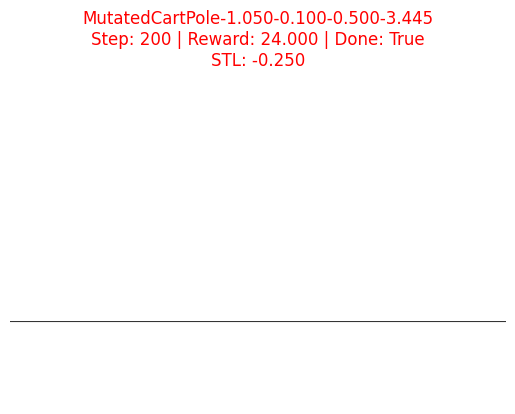

In [13]:
analysis.visualize_deviation(delta, "gifs/any_counterexample.gif")

In [14]:
start = datetime.now()
delta, delta_dist = analysis.min_unsafe_deviation()


================ Min unsafe deviation trial 1 ==============>
(3_w,6)-aCMA-ES (mu_w=2.0,w_1=63%) in dimension 2 (seed=954706, Sat Nov 19 20:43:59 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      6 3.498268111546961e-03 1.0e+00 1.57e-01  1e-01  1e-01 0:41.1
    2     12 2.752249890708944e-02 1.1e+00 1.17e-01  8e-02  1e-01 1:30.5
    3     18 4.454820657164403e-01 1.3e+00 1.02e-01  7e-02  8e-02 2:19.3
    4     24 1.529260029309969e-01 1.1e+00 8.60e-02  5e-02  6e-02 3:06.2
    5     30 4.544477352945952e-02 1.2e+00 7.35e-02  4e-02  5e-02 3:52.0
    6     36 2.368021380287094e-01 1.3e+00 7.14e-02  3e-02  4e-02 4:39.0
    7     42 1.373222005486032e-01 1.4e+00 7.14e-02  3e-02  5e-02 5:27.3
    8     48 1.125092504310346e-01 1.6e+00 6.25e-02  3e-02  3e-02 6:14.5
    9     54 6.470353284850493e-02 1.3e+00 6.80e-02  3e-02  3e-02 7:00.8
   10     60 6.054714328535597e-02 1.1e+00 6.21e-02  3e-02  3e-02 7:48.0
   11     66 5.566021638793925e-02 1.2e+00 4.

In [15]:
print('Time to find min unsafe deviation:', datetime.now() - start)
print(delta, delta_dist)

Time to find min unsafe deviation: 0:31:42.152527
[1.46004579 5.07926895] 0.3545423760870698


STL robustness value: -0.017382747931309894
Initial state: [0.02734254 0.00841849 0.04874525 0.021704  ]


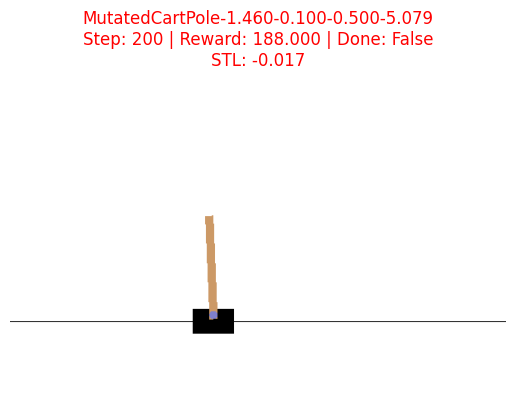

In [16]:
analysis.visualize_deviation(delta, "gifs/min_counterexample.gif")

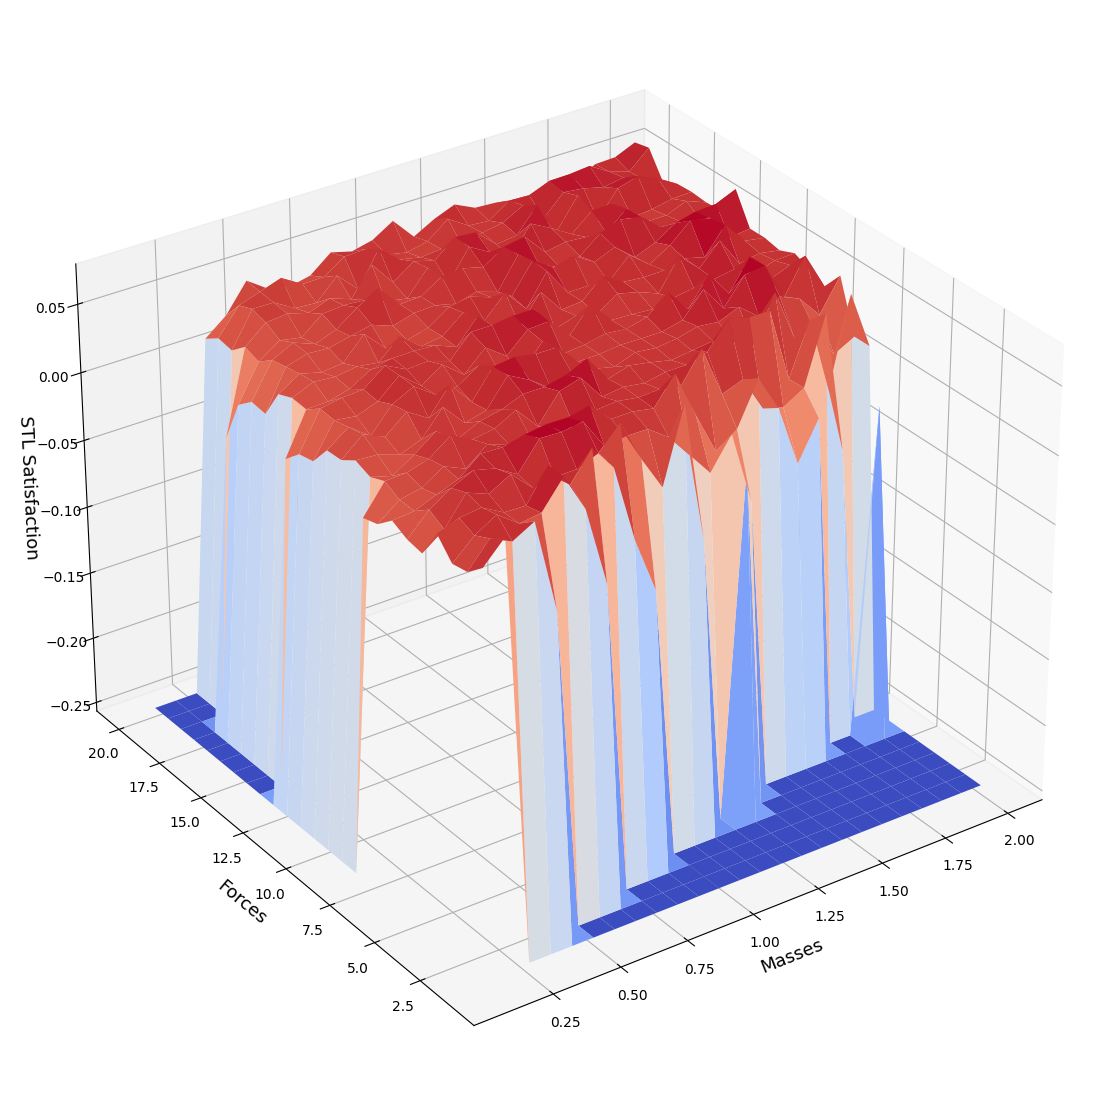

In [36]:
ax, masses, forces, grid_data = analysis.grid_plot(masscart, force_mag, 25, 25, x_name="Masses", y_name="Forces",
                                                   z_name="STL Satisfaction")
ax.view_init(30, -125)
plt.savefig('gifs/robustness-landscape.png', bbox_inches='tight')
plt.show()

In [37]:
# fig, ax = plt.subplots()
# # im = ax.imshow(grid_data, cmap=cm.coolwarm, vmax=0.2, vmin=-0.25)
# im = ax.imshow(grid_data, cmap=cm.coolwarm)
# ax.set_xticks(np.arange(0, len(forces[0]), 3), labels=['{:.2f}'.format(x) for x in forces[0][::3]])
# ax.set_yticks(np.arange(0, len(masses[:, 0]), 3), labels=['{:.2f}'.format(x) for x in masses[:, 0][::3]])
# cbar = ax.figure.colorbar(im)
# cbar.ax.set_ylabel('STL Satisfaction', rotation=-90, va="bottom")

# ax.set_xlabel('Forces')
# ax.set_ylabel('Masses')

# plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
# plt.savefig('gifs/robustness-landscape-heatmap.png')
# plt.show()

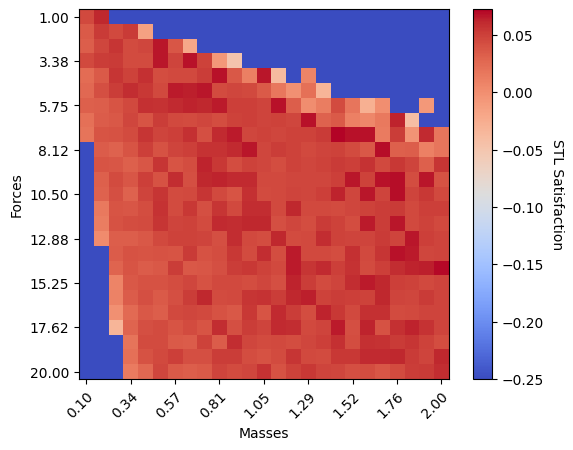

In [38]:
analysis.heatmap(masscart, force_mag, 25, 25, x_name="Masses", y_name="Forces", z_name="STL Satisfaction")
plt.savefig('gifs/robustness-landscape-heatmap.png', bbox_inches='tight')
plt.show()

## Compute robustness boundary

In [18]:
start = datetime.now()
boundary = analysis.robustness_boundary()


================ Min unsafe deviation trial 1 ==============>
(3_w,6)-aCMA-ES (mu_w=2.0,w_1=63%) in dimension 2 (seed=1022967, Sat Nov 19 21:15:59 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      6 7.987087823126543e-07 1.0e+00 3.51e-01  4e-01  5e-01 0:51.0
    2     12 1.419290070687670e-03 1.3e+00 3.62e-01  3e-01  4e-01 1:40.3
    3     18 4.204034451178540e-01 1.4e+00 3.07e-01  2e-01  4e-01 2:32.3
    4     24 1.958612906440405e-01 2.1e+00 4.05e-01  4e-01  7e-01 3:06.9
    5     30 1.036905811963870e-01 2.6e+00 4.09e-01  4e-01  6e-01 3:55.0
    6     36 7.291941072729885e-02 2.1e+00 5.45e-01  6e-01  7e-01 4:20.3
    7     42 -1.308829688934643e-02 1.7e+00 5.41e-01  6e-01  6e-01 4:59.5
    8     48 9.760863819134052e-02 1.9e+00 4.26e-01  4e-01  4e-01 5:33.6
    9     54 1.956871218932028e-01 1.5e+00 5.41e-01  5e-01  6e-01 6:22.8
   10     60 1.192977841375274e-01 1.4e+00 4.84e-01  4e-01  6e-01 7:04.9
   11     66 4.747890378805075e-02 1.7e+00 

    9     54 5.098092869704361e-05 1.3e+00 7.57e-02  3e-02  5e-02 6:53.8
   10     60 9.002945407601864e-06 1.5e+00 6.46e-02  3e-02  4e-02 7:40.0
   11     66 2.859940316505773e-05 1.5e+00 4.60e-02  2e-02  2e-02 8:24.9
   12     72 1.797424521572381e-04 1.2e+00 3.73e-02  1e-02  2e-02 9:11.6
   13     78 2.280271801931519e-05 1.2e+00 3.74e-02  1e-02  2e-02 9:57.7
   14     84 2.582468057843009e-01 1.4e+00 4.85e-02  2e-02  2e-02 10:44.9
termination on timeout=600 (Sat Nov 19 22:08:42 2022)
final/bestever f-value = 2.799947e-01 9.002945e-06
incumbent solution: [0.6375817101433128, 0.2701105992914139]
std deviation: [0.018933217341032125, 0.020727865427820787]
CMAEvolutionStrategyResult(xbest=array([0.66514402, 0.25121625]), fbest=9.002945407601864e-06, evals_best=60, evaluations=85, iterations=14, xfavorite=array([0.63758171, 0.2701106 ]), stds=array([0.01893322, 0.02072787]), stop={'timeout': 600})
{'x': array([0.64481861, 0.24628614]), 'f': 0.2845994803175498, 'g': [-0.00134832362634773

In [21]:
print(boundary)

0.27459948031754977


In [19]:
print('Time to approximate boundary:', datetime.now() - start)

Time to approximate boundary: 1:34:54.826837


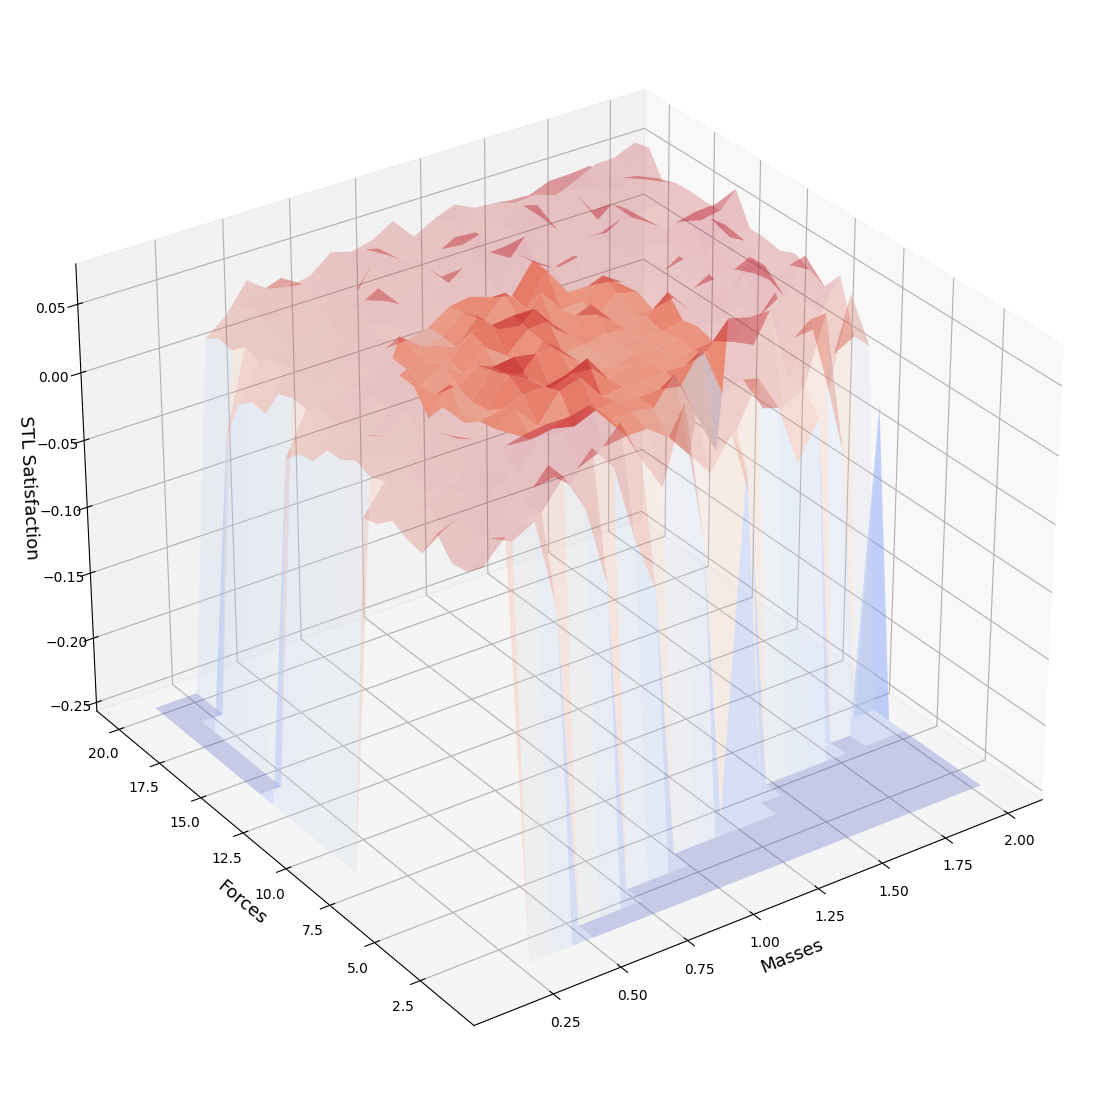

In [39]:
ax, masses, forces, grid_data = analysis.grid_plot(masscart, force_mag, 25, 25, x_name="Masses", y_name="Forces",
                                                   z_name='STL Satisfaction', boundary=boundary)
ax.view_init(30, -125)
plt.savefig('gifs/robustness-landscape-boundary.png', bbox_inches='tight')
plt.show()

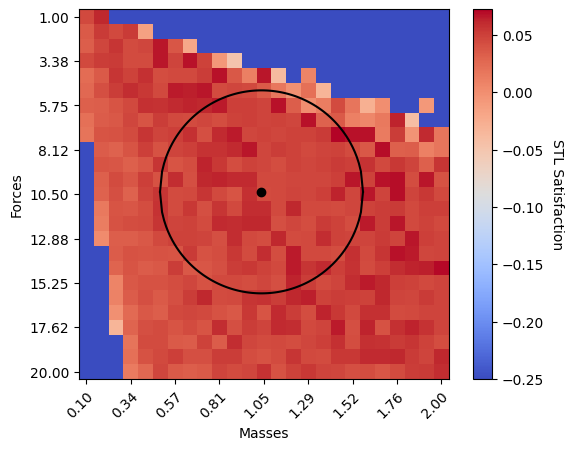

In [40]:
analysis.heatmap(masscart, force_mag, 25, 25, x_name="Masses", y_name="Forces", z_name="STL Satisfaction",
                 boundary=boundary)
plt.savefig('gifs/robustness-landscape-boundary-heatmap.png', bbox_inches='tight')
plt.show()

## Use reward as the property evaluation function

In [18]:
def episode_eval_reward(obs_record, reward_record):
    return reward_record.sum() - 200

In [19]:
analysis_reward = RobustnessAnalysis(env_builder, agent, episode_eval_reward, delta_0, dev_bounds, dist)
analysis_reward.options['falsification_num_trials'] = 1

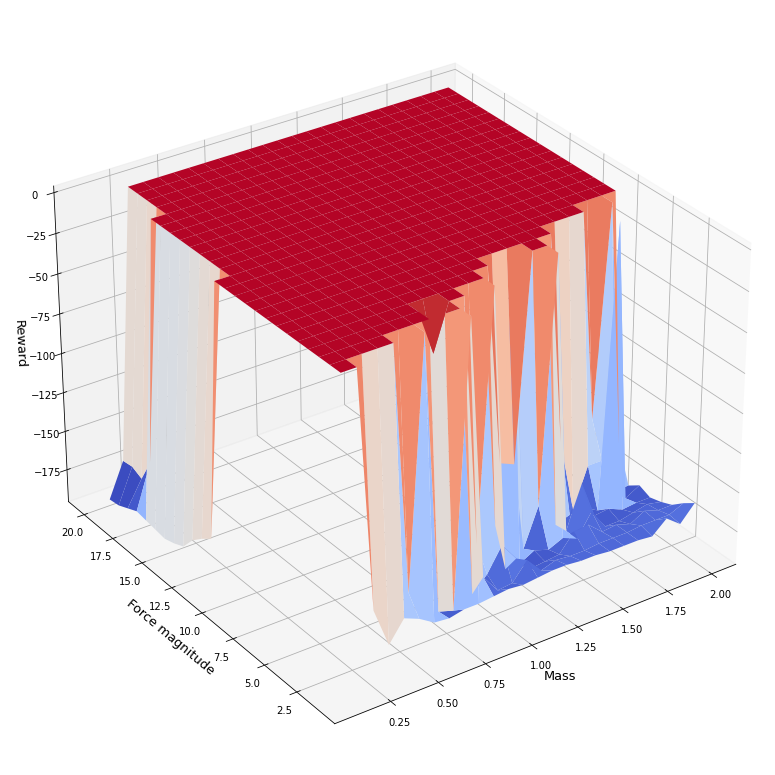

In [20]:
ax, masses, forces, grid_data = analysis_reward.grid_plot(masscart, force_mag, 25, 25, out_dir="data_reward",
                                                          x_name="masses", y_name="forces", z_name='Reward')
ax.set_xlabel('Mass', fontsize=13)
ax.set_ylabel('Force magnitude', fontsize=13)
ax.view_init(30, -125)
plt.savefig('gifs/robustness-landscape-reward.png')
plt.show()